In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import re
import cv2
import random
import numpy as np

# 신경망
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop

import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets as D
from torchvision import transforms as T

from sklearn.model_selection import train_test_split

# plot
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline 

# Dataset

In [3]:
labels = []
images = []
asanas_name = []
images_path = []
images_pixels = []

dataset_path ='/content/drive/MyDrive/Human Pose Estimation/dataset'


# os.listdir()는 지정한 디렉토리 내의 모든 파일과 디렉토리의 list를 리턴한다.
total_classes = os.listdir(dataset_path)
classes_20 = os.listdir(dataset_path)[:20]

for i, directory in enumerate(classes_20):
    asanas_name.append(directory)
    for img in os.listdir(os.path.join(dataset_path,directory)):  # os.path.join(dataset_path,directory) = /content/drive/MyDrive/Human Pose Estimation/dataset/tittibhasana
        if len(re.findall('.png',img.lower())) != 0 or len(re.findall('.jpg',img.lower())) != 0 or len(re.findall('.jpeg',img.lower())) != 0:
            img_path = os.path.join(os.path.join(dataset_path,directory),img)
            images.append(img)
            images_path.append(img_path)
            img_pix = cv2.imread(img_path,3)   # cv2.imread(fileName, flag) : flag (int) – 이미지 파일을 읽을 때의 Option.
            images_pixels.append(cv2.resize(img_pix, (100,100)))
            labels.append(i)
    
print("Total labels: ", len(labels))
print("Total images: ", len(images))
print("Total images path: ", len(images_path))
print("Total Groups Yoga Poses: ", len(asanas_name))
print("Total images_pixels: ", len(images_pixels))

Total labels:  1015
Total images:  1015
Total images path:  1015
Total Groups Yoga Poses:  20
Total images_pixels:  1015


In [4]:
print('Total Yoga poses groups:', len(classes_20), '\n')

classes = []
for class_ in classes_20:
    classes.append(class_)
    print(class_)

Total Yoga poses groups: 20 

tittibhasana
anantasana
chakravakasana
parighasana
eka pada rajakapotasana ii
ashtanga namaskara
kapotasana
marichyasana i
janu sirsasana
hanumanasana
phalakasana
ananda balasana
krounchasana
adho mukha svanasana
yoganidrasana
kurmasana
vajrasana
garbha pindasana
padmasana
eka pada koundinyanasana i


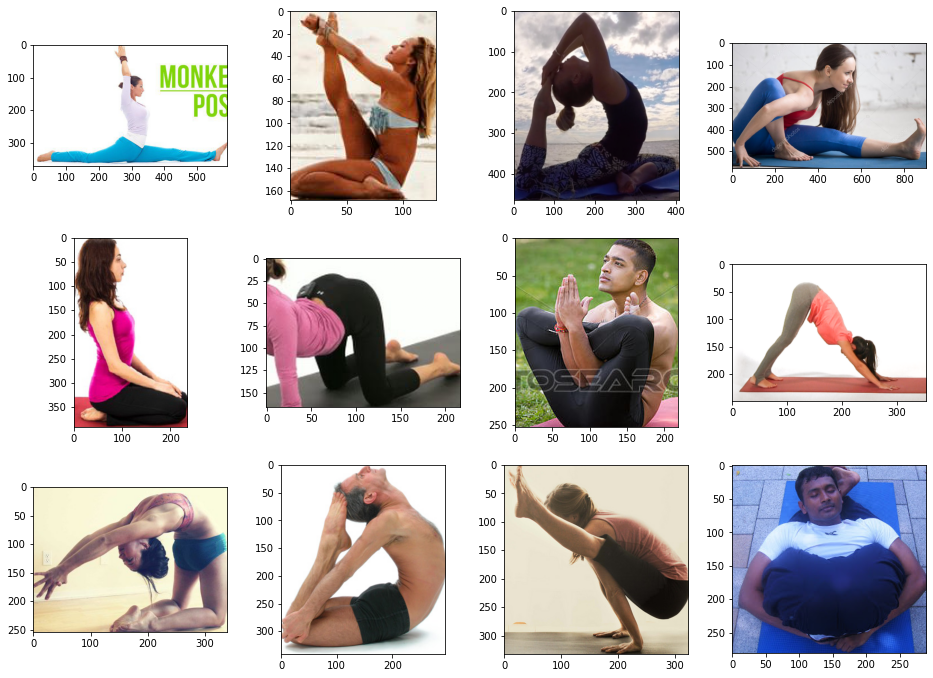

In [5]:
fig = plt.gcf()
fig.set_size_inches(16, 16)

next_pix = images_path
random.shuffle(next_pix)

for i, img_path in enumerate(next_pix[0:12]):
    
    sp = plt.subplot(4, 4, i + 1)
    sp.axis('On')

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

# Dataset pre-processing

In [6]:
# analyzing the dataset
# zip() 함수를 사용하면 마치 옷의 지퍼를 올리는 것 처럼 양 측에 있는 데이터를 하나씩 차례로 짝을 지어줌
shuf = list(zip(images_pixels,labels))

train_data, labels_data = zip(*shuf)

In [7]:
# Separating x_train and y_train
# Turning the 2d image into a numpy array
# Normalizing to values ​​between 0 and 1
X_data = np.array(train_data) / 255 
Y_data =  to_categorical(labels_data, num_classes = 20) # 20-dimensional output vector, to_categorical: 레이블들을 서로 관계가 성립하지 않게 오직 0과 1로 표현하는 것
print(Y_data[0])
print(Y_data[1])
print(Y_data[57])
print(Y_data[114])
print(Y_data[1010])
print(len(Y_data))

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
1015


In [8]:
print("Number of dataset elements: {}". format(len(train_data)))

print("X total: ", X_data.shape)
print("Y total: ", Y_data.shape)

Number of dataset elements: 1015
X total:  (1015, 100, 100, 3)
Y total:  (1015, 20)


In [9]:
# Separating a part for training (70%) and another for validation (30%)
X_train, X_val, Y_train, Y_val = train_test_split(X_data, Y_data, test_size = 0.2, random_state=101)

print("X training : ", len(X_train))
print("X Validation quantity : ", len(X_val))
print("Y test : ", len(Y_train))
print("Y Validation quantity : ", len(Y_val))

X training :  812
X Validation quantity :  203
Y test :  812
Y Validation quantity :  203


In [10]:
image_shape = (100,100)
num_classes = 20
seed = 10
BATCH_SIZE = 16

image_shape[0], image_shape[1]

(100, 100)

# Model 1: Convolutional Neural Networks

Note: A common debugging workflow: add() + summary()

When building a new sequential architecture, it is useful to incrementally stack add() layers and print model summaries frequently. For example, this allows you to monitor how a stack of Conv2D and MaxPooling2D layers is downsampling image resource maps.

In [11]:
# Creating and training the Sequential model
# Sequential: Keras model of adding layers (like a lego)
# Conv2D: Layer with kernels (filters) that run through the image extracting features (feature maps)
# MaxPooling2D: Layer that reduces the dimensionality of 2D feature maps
# Flatten: Layer that transforms a 2D feature map into a vector for final classifier
# Dense: Layer where all inputs are connected to each neuron (fully connected)
# Dropout: Layer uses during training that randomly drops a percentage of connections (reduces overfitting)


model = Sequential()
model.add(Conv2D(filters=35, kernel_size=(10, 10), activation='relu', input_shape=(100,100,3)))   
# 첫번째 인자(35): filters값(미지에서 특징 (feature)을 분리해내는 기능, 출력 공간의 차원 (깊이)을 결정)
# 두번째 인자(10,10): kernel_size, 합성곱에 사용되는 필터 (=커널)의 크기
model.add(MaxPooling2D(pool_size=(2, 2)))   # 합성곱에 의해 얻어진 Feature map으로부터 값을 샘플링해서 정보를 압축하는 과정을 의미

model.add(Conv2D(filters=60, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(60, kernel_size=(3,3), activation='relu'))


In [12]:
# Dense 층 추가 (분류를 담당하는 Dense 층 (Fully-connected layer)을 세 개 추가)
model.add(Flatten())
model.add(Dense(40, activation='relu'))   # 첫번째 인자 : 출력 뉴런의 수를 설정
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 91, 91, 35)        10535     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 45, 45, 35)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 43, 43, 60)        18960     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 21, 21, 60)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 19, 19, 60)        32460     
                                                                 
 flatten (Flatten)           (None, 21660)             0

In [13]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


In [14]:
# Train with the data part
batch_size = 32
epochs = 50

# 최적화 모델 저장(ModelCheckpoint)
# callbacks.ModelCheckpoint : 모델이 최적의 모델을 갖추었을 때, 파일을 저장. (대체적으로 Earlystopping과 같이 사용) && 모델 훈련 시 리스트 형태로 callbacks 함수에 넣는다.
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='model.h5',
        monitor='val_loss', save_best_only=True, verbose=2),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,verbose=2)
]

history = model.fit(X_train, Y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks = callbacks_list,
                    verbose=1,
                    validation_data=(X_val, Y_val))


Epoch 1/50
26/26 [==============================] - ETA: 0s - loss: 3.0078 - accuracy: 0.0431
Epoch 00001: val_loss improved from inf to 2.98035, saving model to model.h5
26/26 [==============================] - 30s 1s/step - loss: 3.0078 - accuracy: 0.0431 - val_loss: 2.9803 - val_accuracy: 0.1232
Epoch 2/50
26/26 [==============================] - ETA: 0s - loss: 2.9720 - accuracy: 0.0887
Epoch 00002: val_loss improved from 2.98035 to 2.88140, saving model to model.h5
26/26 [==============================] - 25s 981ms/step - loss: 2.9720 - accuracy: 0.0887 - val_loss: 2.8814 - val_accuracy: 0.1527
Epoch 3/50
26/26 [==============================] - ETA: 0s - loss: 2.7645 - accuracy: 0.1552
Epoch 00003: val_loss improved from 2.88140 to 2.74544, saving model to model.h5
26/26 [==============================] - 26s 987ms/step - loss: 2.7645 - accuracy: 0.1552 - val_loss: 2.7454 - val_accuracy: 0.1773
Epoch 4/50
26/26 [==============================] - ETA: 0s - loss: 2.5762 - accuracy:

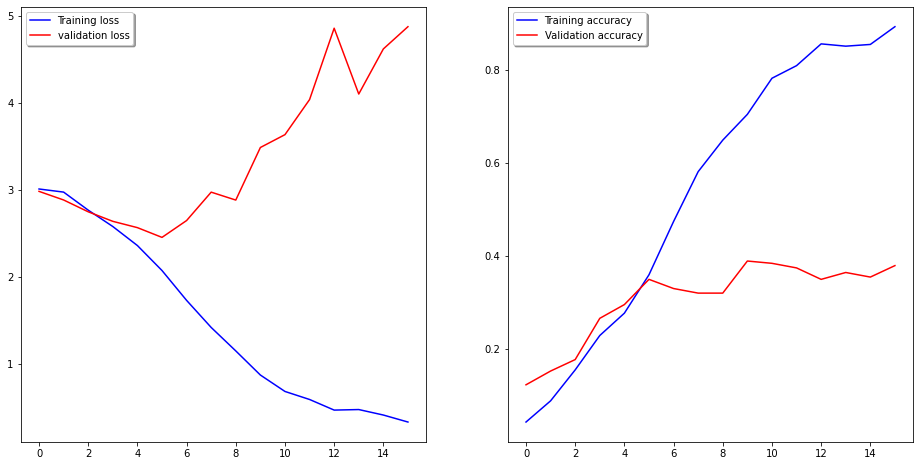

In [15]:
# Let's see how training went?
# X_train, X_val, Y_train, Y_val

fig, ax = plt.subplots(1,2, figsize=(16,8))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [16]:
from tensorflow.keras.models import load_model
# Load the best saved model
model = load_model('model.h5')

# Test
score = model.evaluate(X_val, Y_val, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 2.451178550720215
Test accuracy: 0.3497537076473236


# Model 2: Convolutional Neural Networks + Transfer Learning

In the case of our dataset, you don't need to create the Generator as we have a significant sample.

In [17]:
#from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.applications.vgg16 import VGG16

## VGG16

In [18]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_shape[0], image_shape[1], 3))
# print(image_shape[0], image_shape[1], 3)    # 100 100 3


x = base_model.output   # shape=(None, 3, 3, 512)
x = Flatten()(x)      # shape=(None, 4608)
x = Dense(100, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax', kernel_initializer='random_uniform')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.summary()
# Freezing pretrained layers
for layer in base_model.layers:
    layer.trainable=False
    
optimizer = Adam()
model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0     

In [19]:
epochs = 80

# Callback to save the best template
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='model.h5',
        monitor='val_loss', save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,verbose=1)
]

#Training
history = model.fit(X_train, Y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks = callbacks_list,
                    verbose=1,
                    validation_data=(X_val, Y_val))

Epoch 1/80
26/26 [==============================] - ETA: 0s - loss: 2.7115 - accuracy: 0.2414
Epoch 00001: val_loss improved from inf to 2.18847, saving model to model.h5
26/26 [==============================] - 103s 4s/step - loss: 2.7115 - accuracy: 0.2414 - val_loss: 2.1885 - val_accuracy: 0.4680
Epoch 2/80
26/26 [==============================] - ETA: 0s - loss: 1.7350 - accuracy: 0.6281
Epoch 00002: val_loss improved from 2.18847 to 1.40881, saving model to model.h5
26/26 [==============================] - 98s 4s/step - loss: 1.7350 - accuracy: 0.6281 - val_loss: 1.4088 - val_accuracy: 0.6897
Epoch 3/80
26/26 [==============================] - ETA: 0s - loss: 1.0366 - accuracy: 0.7968
Epoch 00003: val_loss improved from 1.40881 to 1.08508, saving model to model.h5
26/26 [==============================] - 99s 4s/step - loss: 1.0366 - accuracy: 0.7968 - val_loss: 1.0851 - val_accuracy: 0.7291
Epoch 4/80
26/26 [==============================] - ETA: 0s - loss: 0.6861 - accuracy: 0.86

In [20]:
from tensorflow.keras.models import load_model
# Load the best saved model
model = load_model('model.h5')

# Test
score = model.evaluate(X_val, Y_val, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.5968660116195679
Test accuracy: 0.8177340030670166


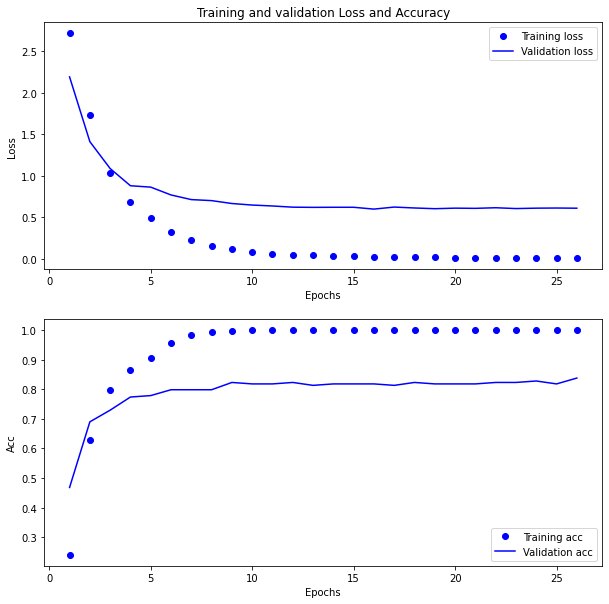

In [21]:
# Training curves
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs_x = range(1, len(loss_values) + 1)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(epochs_x, loss_values, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(2,1,2)
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs_x, acc_values, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc_values, 'b', label='Validation acc')
#plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

## InceptionResNetV2

In [22]:
base_model2 = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(image_shape[0], image_shape[1], 3))

x = base_model2.output
x = Flatten()(x)
x = Dense(100, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax', kernel_initializer='random_uniform')(x)

model = Model(inputs=base_model2.input, outputs=predictions)
model.summary()

# Freezing pretrained layers
for layer in base_model2.layers:
    layer.trainable=False
    
optimizer = Adam()
model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

219070464/219055592 [==============================] - 2s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 49, 49, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 49, 49, 32)  96          ['conv2d_3[0][0]']               
 alization)                                                                                       
                         

In [23]:
epochs = 80

# Callback to save the best template
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='model.h5',
        monitor='val_loss', save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,verbose=1)
]

#Training
history = model.fit(X_train, Y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks = callbacks_list,
                    verbose=1,
                    validation_data=(X_val, Y_val))

Epoch 1/80
26/26 [==============================] - ETA: 0s - loss: 2.7578 - accuracy: 0.1687
Epoch 00001: val_loss improved from inf to 2.38237, saving model to model.h5
26/26 [==============================] - 51s 1s/step - loss: 2.7578 - accuracy: 0.1687 - val_loss: 2.3824 - val_accuracy: 0.3596
Epoch 2/80
26/26 [==============================] - ETA: 0s - loss: 1.9176 - accuracy: 0.4914
Epoch 00002: val_loss improved from 2.38237 to 1.97668, saving model to model.h5
26/26 [==============================] - 33s 1s/step - loss: 1.9176 - accuracy: 0.4914 - val_loss: 1.9767 - val_accuracy: 0.4483
Epoch 3/80
26/26 [==============================] - ETA: 0s - loss: 1.4037 - accuracy: 0.6490
Epoch 00003: val_loss improved from 1.97668 to 1.82939, saving model to model.h5
26/26 [==============================] - 33s 1s/step - loss: 1.4037 - accuracy: 0.6490 - val_loss: 1.8294 - val_accuracy: 0.4828
Epoch 4/80
26/26 [==============================] - ETA: 0s - loss: 1.0537 - accuracy: 0.750

In [24]:
from tensorflow.keras.models import load_model
# Load the best saved model
model = load_model('model.h5')

# Test
score = model.evaluate(X_val, Y_val, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.6625474691390991
Test accuracy: 0.5320196747779846


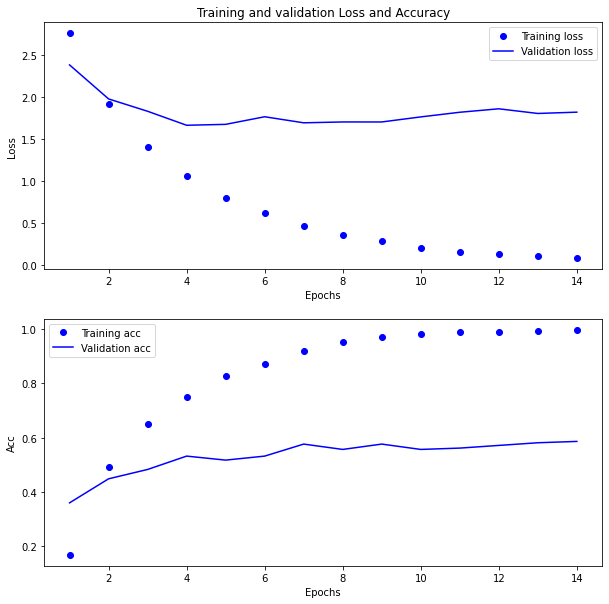

In [25]:
# Training curves
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs_x = range(1, len(loss_values) + 1)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(epochs_x, loss_values, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(2,1,2)
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs_x, acc_values, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc_values, 'b', label='Validation acc')
#plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

# 1.Model 1 : CNN
Test loss: 2.451178550720215

Test accuracy: 0.3497537076473236

# 2. Model 2: CNN + InceptionResNetV2

Test loss: 1.6625474691390991

Test accuracy: 0.5320196747779846

# 3. Model 3: CNN + VGG16
Test loss: 0.5968660116195679

Test accuracy: 0.8177340030670166